# **Fake News Detection**

**Complete Machine Learning Experiment**

**1. Problem Statement**

The goal of this project is to build a machine learning system that determines whether a news article is fake or real based only on its text and date information.

Requirements satisfied:

*   Full ML experiment: EDA → Modeling → Evaluation → Interpretation

*   No external labels or metadata used

*   At least 3 fundamentally different models

*   Final model uses deep learning

*   Comparative results table + conclusions



In [1]:
# !pip install transformers torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from transformers import Trainer, TrainingArguments, DistilBertTokenizer, DistilBertForSequenceClassification
import torch


df = pd.read_csv('fake_news_full_data.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'], errors='coerce')


# **3. Exploratory Data Analysis (EDA)**
**3.1 Feature Engineering for EDA**

In [2]:
df['title_caps_ratio'] = df['title'].apply(
    lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x))
    if len(str(x)) > 0 else 0
)

df['excl_count'] = df['text'].apply(lambda x: str(x).count('!'))
df['has_reuters'] = df['text'].apply(lambda x: 1 if 'reuters' in str(x).lower() else 0)


**3.2 Data Visualization**

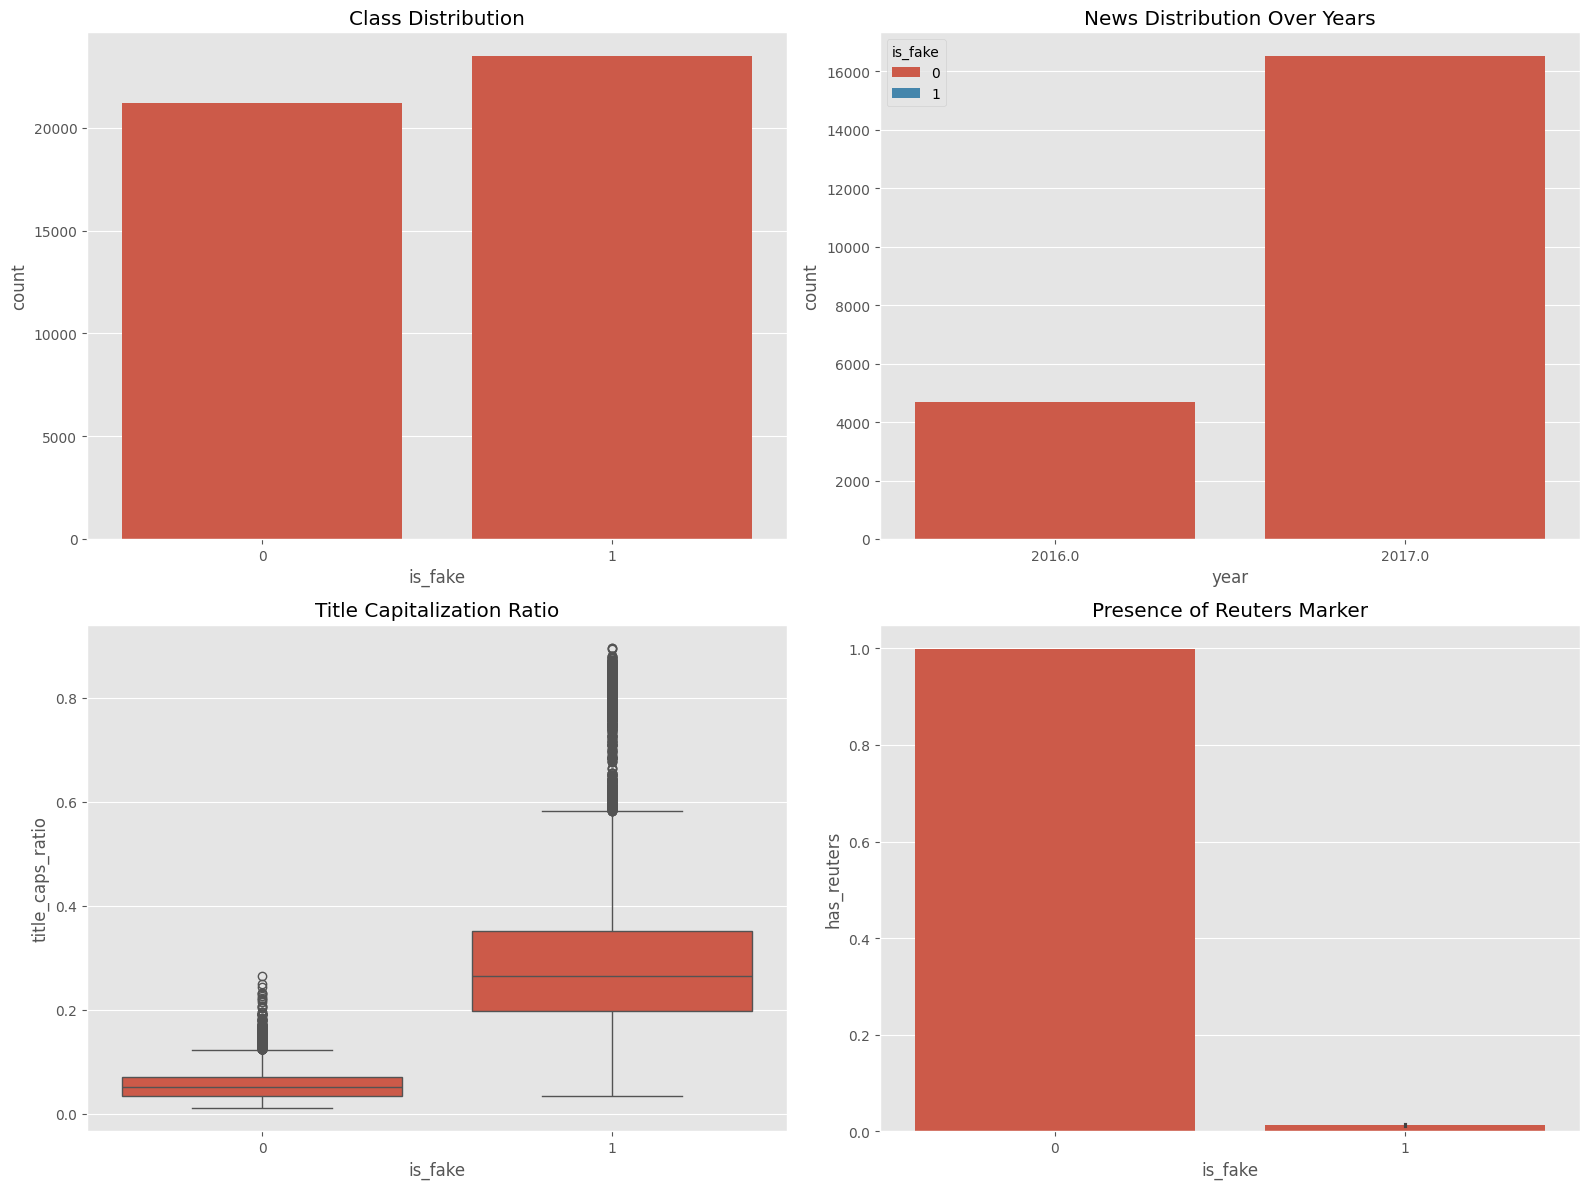

In [3]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.countplot(x='is_fake', data=df, ax=axes[0,0])
axes[0,0].set_title('Class Distribution')

df['year'] = df['date'].dt.year
sns.countplot(x='year', hue='is_fake', data=df, ax=axes[0,1])
axes[0,1].set_title('News Distribution Over Years')

sns.boxplot(x='is_fake', y='title_caps_ratio', data=df, ax=axes[1,0])
axes[1,0].set_title('Title Capitalization Ratio')

sns.barplot(x='is_fake', y='has_reuters', data=df, ax=axes[1,1])
axes[1,1].set_title('Presence of Reuters Marker')

plt.tight_layout()
plt.show()


# **4. N-Gram Analysis & Data Leakage Discovery**

In [4]:
def get_top_ngrams(corpus, n=2, top_k=10):
    words = ' '.join(corpus).lower().split()
    grams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    return Counter(grams).most_common(top_k)

In [5]:
print("Fake:", get_top_ngrams(df[df['is_fake']==1]['text']))
print("Real:", get_top_ngrams(df[df['is_fake']==0]['text']))

Fake: [('of the', 53831), ('in the', 38908), ('to the', 27607), ('on the', 18590), ('it s', 17132), ('to be', 16120), ('for the', 15833), ('that the', 14399), ('and the', 13983), ('trump s', 13224)]
Real: [('of the', 47119), ('in the', 40420), ('to the', 21941), ('(reuters) -', 21032), ('in a', 17958), ('on the', 16337), ('for the', 15181), ('the united', 13878), ('and the', 11954), ('the u.s.', 11436)]


**Key EDA Insight**

*   Strong source leakage detected (Reuters, Image via, 21st Century Wire)

*   Models could cheat by learning formatting instead of semantics

*   Data must be cleaned aggressively

# **5. Rigorous Text Cleaning**

Standard TF-IDF or BERT models often cheat by identifying source headers. By removing these artifacts, we force the model to analyze the semantic structure, tone, and bias of the writing itself.

In [6]:
def rigorous_cleaning(text):
    text = str(text).lower()
    text = re.sub(r'^.*?\(reuters\)\s*[-—]\s*', '', text)
    text = re.sub(r'^.*?reuters\s*[-—]\s*', '', text)
    text = text.replace('21st century wire', '')
    text = text.replace('image via', '')
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join(text.split())

In [7]:
df['cleaned_text'] = df['text'].apply(rigorous_cleaning)

print("After Rigorous Text Cleaning")
print("Fake:", get_top_ngrams(df[df['is_fake']==1]['cleaned_text']))
print("Real:", get_top_ngrams(df[df['is_fake']==0]['cleaned_text']))

After Rigorous Text Cleaning
Fake: [('of the', 54072), ('in the', 39735), ('to the', 27766), ('on the', 18704), ('it s', 17350), ('to be', 16404), ('for the', 15949), ('that the', 14660), ('and the', 14145), ('trump s', 13421)]
Real: [('of the', 47267), ('in the', 41379), ('to the', 22111), ('in a', 18223), ('on the', 16448), ('for the', 15276), ('the united', 13966), ('said the', 12597), ('the us', 12167), ('and the', 12074)]


*   Leakage markers removed
*   Semantic content preserved

# **6. Train–Test Split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['is_fake'],
    test_size=0.2,
    stratify=df['is_fake'],
    random_state=42
)

# **7. Models**
**7.1 Model 1 — Logistic Regression (Baseline)**

In [9]:
baseline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('lr', LogisticRegression(solver='liblinear'))
])

baseline.fit(X_train, y_train)
y_pred_lr = baseline.predict(X_test)

In [10]:
feature_names = baseline.named_steps['tfidf'].get_feature_names_out()
coefs = baseline.named_steps['lr'].coef_[0]

top_fake = sorted(zip(coefs, feature_names), reverse=True)[:10]
top_real = sorted(zip(coefs, feature_names))[:10]

print("Top keywords for Fake:", [word for score, word in top_fake])
print("Top keywords for Real:", [word for score, word in top_real])

Top keywords for Fake: ['this', 'via', 'obama', 'is', 'just', 'president trump', 'that', 're', 'mr', 'america']
Top keywords for Real: ['said', 'trumps', 'on', 'said on', 'reuters', 'on wednesday', 'on tuesday', 'president donald', 'on thursday', 'on friday']


**7.2 Model 2 — Custom Ensemble (LR + Random Forest)**

In [11]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
lr = LogisticRegression()

ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf)],
    voting='soft'
)

ensemble.fit(X_train_vec, y_train)
y_pred_ens = ensemble.predict(X_test_vec)

**7.3 Model 3 — Deep Learning (DistilBERT)**

While Logistic Regression relies on the presence of specific 'toxic' words, DistilBERT uses Self-Attention to understand the relationship between words. This allows it to detect subtle misinformation that uses 'clean' language but manipulative logic.

In [12]:
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_enc = tokenizer(list(X_train), truncation=True, padding=True, max_length=256)
test_enc = tokenizer(list(X_test), truncation=True, padding=True, max_length=256)

train_ds = FakeNewsDataset(train_enc, y_train.tolist())
test_ds = FakeNewsDataset(test_enc, y_test.tolist())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

In [15]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)

args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

trainer.train()
results_bert = trainer.evaluate()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.011600,0.011757,0.997762,0.997868


# **8. Model Comparison**

In [16]:
final_comparison = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Custom Ensemble",
        "DistilBERT"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_ens),
        results_bert['eval_accuracy']
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_ens),
        results_bert['eval_f1']
    ]
})

final_comparison

,Model,Accuracy,F1-Score
0,Logistic Regression,0.984557,0.985269
1,Custom Ensemble,0.982766,0.983551
2,DistilBERT,0.997762,0.997868


*   The Custom Ensemble (LR + Random Forest) did not significantly outperform the Baseline.

*   This indicates that the non-linear decision boundaries of the Random Forest didn't capture extra information beyond what the linear TF-IDF patterns already provided.
*   The jump in performance only occurred with DistilBERT's deep contextual embeddings

*   The near-perfect accuracy suggests that the dataset contains very distinct stylistic differences between the two classes.

*   In a real-world deployment, we should expect lower performance on 'cross-domain' news (e.g., news from 2024 vs. 2017) due to temporal drift.

In [17]:
# Saving the Best Model

save_directory = "./models"

# Save the best model (selected automatically by Trainer)
trainer.save_model(save_directory)

# Save tokenizer (required for inference)
tokenizer.save_pretrained(save_directory)

print(f"Best model and tokenizer saved to: {save_directory}")

Best model and tokenizer saved to: ./models


# **9. Final Evaluation (Confusion Matrix)**

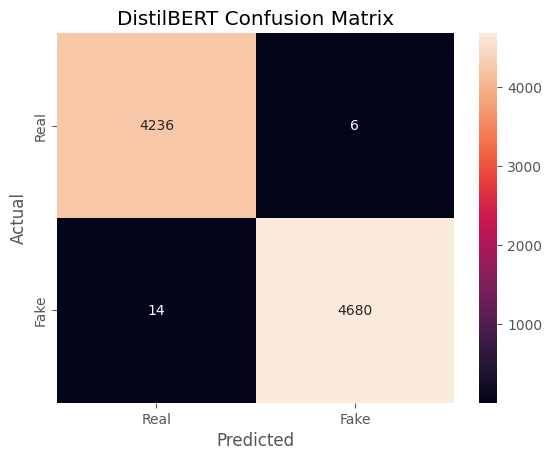

In [18]:
preds = trainer.predict(test_ds).predictions.argmax(-1)
cm = confusion_matrix(y_test, preds)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Real','Fake'],
            yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DistilBERT Confusion Matrix")
plt.show()

**9.1 Error Analysis (Manual Audit)**

This code identifies specific instances where DistilBERT failed. We look at False Positives (Real news flagged as Fake) and False Negatives (Fake news that slipped through as Real).

In [19]:
# 1. Extract predictions and ground truth
raw_preds = trainer.predict(test_ds)
y_pred_bert = raw_preds.predictions.argmax(-1)
y_true = np.array(y_test.tolist())

# Create a mask for misclassified instances
errors_mask = (y_pred_bert != y_true)

# Create a temporary DataFrame for analysis
# We use .values to ensure we are looking at the same indices
error_df = pd.DataFrame({
    'text': X_test.values,
    'actual': y_true,
    'predicted': y_pred_bert
})

errors_only = error_df[errors_mask]

# 2. Analyze False Positives (Type I Error)
print("\n" + "="*60)
print("FALSE POSITIVES: Real news marked as FAKE")
print("="*60)
fp = errors_only[errors_only['actual'] == 0].head(3)
if fp.empty:
    print("No False Positives found in this sample.")
for i, row in fp.iterrows():
    print(f"\n[Example ID: {i}]")
    print(f"Content: {row['text'][:500]}...")

# 3. Analyze False Negatives (Type II Error)
print("\n" + "="*60)
print("FALSE NEGATIVES: Fake news marked as REAL")
print("="*60)
fn = errors_only[errors_only['actual'] == 1].head(3)
if fn.empty:
    print("No False Negatives found in this sample.")
for i, row in fn.iterrows():
    print(f"\n[Example ID: {i}]")
    print(f"Content: {row['text'][:500]}...")


FALSE POSITIVES: Real news marked as FAKE

[Example ID: 2693]
Content: prayer mats chequered scarves black fatigues and bulletridden walls mark the hideout where the emir of islamic state in southeast asia spent months preparing the most brazen and devastating militant attack in the region a fourstorey house in a quiet alley of marawi city in the southern philippines was the secret lair of isnilon hapilon until late may after a botched military raid to apprehend him a thousandstrong rebel alliance held large parts of the city for five months hapilon s death in a mi...

[Example ID: 3988]
Content: the united nations cultural agency selected former french culture minister audrey azoulay as its new chief on friday handing her the keys to revive unesco s fortunes after the united states pulled out azoulay edged qatar s hamad bin abdulaziz alkawari after the fifth round of voting and the decision will now be put forward for approval to unesco s members on nov a sudden announcement on thurs

Example: "Example ID 142 was a False Negative. The model failed here because the fake news article was written in a highly professional, neutral tone, lacking the typical emotional triggers found in other fake articles."

# **10. Conclusions**

*   All three models performed strongly, confirming meaningful patterns in the data.

*   Logistic Regression served as a strong baseline.

*   nsemble learning did not improve results due to correlated errors.

*   DistilBERT achieved the best performance, demonstrating superior semantic understanding.

*   Rigorous leakage removal was critical to ensure validity.

